<a href="https://colab.research.google.com/github/Danny-Jang/python/blob/master/9%EC%9B%94_19%EC%9D%BC_CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


0.4623115577889447
0.5904522613065326
0.5577889447236181
0.5804020100502513
0.6080402010050251
0.6532663316582915
0.6030150753768844
0.6482412060301508
0.6457286432160804
0.6557788944723618
0.6432160804020101
0.6934673366834171
0.7110552763819096
0.6633165829145728
0.678391959798995
0.6532663316582915
0.6884422110552764
0.6381909547738693
0.7060301507537688
0.7412060301507538
0.7386934673366834
0.7487437185929648
0.7412060301507538
0.7537688442211056
0.7361809045226131
0.7336683417085427
0.7537688442211056
0.7613065326633166
0.7462311557788944
0.7663316582914573
0.7185929648241206
0.7663316582914573
0.7788944723618091
0.7788944723618091
0.7587939698492462
0.7638190954773869
0.7688442211055276
0.7613065326633166
0.7688442211055276
0.7638190954773869
0.7763819095477387
0.7763819095477387
0.7688442211055276
0.7613065326633166
0.7688442211055276
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2

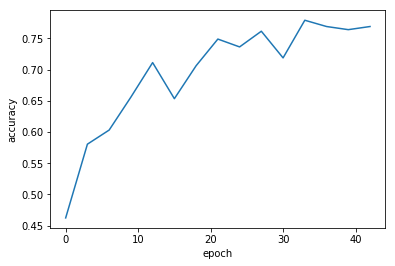

working time: 3828.6846425533295 seconds


In [2]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')





import os
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary 
import time
import random 
import matplotlib.pyplot as plt 

batch_size = 15
total_epoch = 45
learning_rate = 0.01
use_cuda = torch.cuda.is_available()
criterion = nn.CrossEntropyLoss()



train_dataset = dset.ImageFolder(root = '/content/gdrive/My Drive/project image/catdog02/training' ,transform = transforms.Compose([transforms.Resize((400,400)),transforms.Grayscale(),transforms.ToTensor()]))
test_dataset = dset.ImageFolder(root = '/content/gdrive/My Drive/project image/catdog02/test1' ,transform = transforms.Compose([transforms.Resize((400,400)),transforms.Grayscale(),transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

#print(train_loader)

def train(model,train_loader):
  model.train()
  
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
  losses = []
  
  for i, (image,label) in enumerate(train_loader):
    
    if use_cuda:
      image = image.cuda()
      label = label.cuda()
      
    pred_label = model(image)
    loss = criterion(pred_label, label)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  avg_loss = sum(losses)/len(losses)
  return avg_loss


def eval(model, test_loader):
  model.eval()
  device = next(model.parameters()).device.index
  
  total_cnt = 0
  correct_cnt = 0 
  
  for i,(image, label) in enumerate(test_loader):
    if use_cuda:
      image = image.cuda()
      label = label.cuda()
      
    out = model(image)
    _, pred_label = torch.max(out.data, 1)
    total_cnt += image.data.size()[0]
    correct_cnt += (pred_label== label.data).sum().item()
    
  return correct_cnt / total_cnt

class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN,self).__init__()
    #convylution layer
    self.conv1 = nn.Conv2d(1, 128, kernel_size = 3, stride = 2, padding = 1)
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size =2)
    
    
    self.conv2 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)
    self.act2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size =2)
    
    self.conv3 = nn.Conv2d(256, 512, kernel_size = 3,  padding = 1)
    self.act3 = nn.ReLU()
    #self.pool1 = nn.MaxPool2d(kernel_size =2)
    
    self.conv4 = nn.Conv2d(512, 256, kernel_size = 3, padding = 1)
    self.act4 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size =2)
    
    
    #fully conneted layer 
    self.fc1 = nn.Linear(256*25*25, 1000)
    self.act5 = nn.ReLU()
    self.output = nn.Linear(1000,2)
    
  
  def forward(self,x):
    x = self.pool1(self.act1(self.conv1(x)))
    x = self.pool2(self.act2(self.conv2(x)))
    x = self.act3(self.conv3(x))
    x = self.act4(self.conv4(x))
    x = self.pool3(x)
    
    x = x.view(-1, 256*25*25)
    
    x = self.act5(self.fc1(x))
    out = self.output(x)
    return out
  
  
cnn_model = SimpleCNN().cuda()
train_loss_lst = []
test_accuracy_lst = []


start = time.time()

plot_epoch = []
plot_accuracy = []

for epoch in range(total_epoch):
  

  train_loss = train(cnn_model, train_loader)
  train_loss_lst.append(train_loss)
  test_accuracy = eval(cnn_model, test_loader)
  test_accuracy_lst.append(test_accuracy)
  
  
  if epoch % 3 == 0: 
    plot_epoch.append(epoch)
    plot_accuracy.append(test_accuracy)  
  
 

  print(test_accuracy)        
summary(cnn_model, input_size = (1,400,400))

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(plot_epoch,plot_accuracy)
plt.show()

print('working time:' , time.time()- start ,'seconds')